# Project 1: Astronomy Wordle Game  
*Authors: Eling Cheng and Allison Trusko*   
Github Repository: https://github.com/truskoa1/Astro1221-Wordle.git

---

## 📌 Introduction
In this project, we implement a **Wordle-style game** using astronomy terms.  
Players guess 5-letter astronomy words with feedback given in color-coded form (green, yellow, gray).  

Goals:
- Demonstrate Python skills from **Weeks 1–4** (OOP, data structures, file I/O, NumPy, Matplotlib).
- Show how fundamental programming tools can build a useful educational game.
- Track player statistics across multiple games.  

---

## 🎮 How to Play
- You have **6 attempts** to guess the secret word.
- Feedback after each guess:
  - 🟩 = correct letter in the correct spot  
  - 🟨 = letter is in the word but wrong spot  
  - ⬜ = letter not in the word  
- After 3 failed guesses, you’ll receive a **subtle astronomy hint from Claude AI**.

---

## 🔍 Features
- Difficulty levels: **Easy / Medium / Hard**  
- Color-coded feedback like Wordle  
- Claude AI integration for hints  
- External `.txt` files for word lists (easy to expand or customize)



We will first start by loading in the API key, as shown below

### Setup for Anthropic API

- Installs required packages (`python-dotenv` and `anthropic`).  
- Imports libraries for environment variables, randomness, markdown display, and the Anthropic API.  
- Loads environment variables from a `.env` file.  
- Retrieves the Anthropic API key from the environment.  
- Prints a warning if the API key is missing, reminding the user to add it to the `.env` file.  


In [9]:
!pip install python-dotenv anthropic

import os
import random
from dotenv import load_dotenv
from IPython.display import display, Markdown
from anthropic import Anthropic

# Load environment variables
load_dotenv()
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")

if not ANTHROPIC_API_KEY:
    print("⚠️ Missing Anthropic API key! Add it to your .env file as ANTHROPIC_API_KEY=your_key_here")

# PlayerStats Class

This class is responsible for storing and displaying a player’s game statistics. It has three main parts:

**Initialization:**  
- Creates a dictionary to store game data.  
- Tracks how many times the player wins in 1–6 guesses.  
- Keeps a separate slot for losses.  
- Stores total wins and total losses.  

**Recording a Game:**  
- Updates the statistics after each game.  
- If the player wins, the correct slot for the number of guesses is incremented, and total wins increase.  
- If the player loses, the losses slot and total losses are incremented.  

**Plotting a Histogram:**  
- Uses matplotlib to create a bar chart showing performance.  
- Converts stored data into a format for plotting and adds labels.  
- Highlights the losses bar in a different color.  
- Calculates the average number of guesses per win and shows it as a dashed line if available.  
- Adds a title, axis labels, and a legend, then displays the chart.  


In [10]:
class PlayerStats:
    def __init__(self):
        # guess_distribution: number of times player guessed 1–6 + losses
        self.data = {
            "guess_distribution": [0, 0, 0, 0, 0, 0, 0],  # 1–6 guesses + losses
            "wins": 0,
            "losses": 0
        }

    def record_game(self, attempts, won):
        """
        Update stats after a game.
        - attempts: number of guesses used (1–6)
        - won: True if player won, False if lost
        """
        if won:
            self.data["guess_distribution"][attempts - 1] += 1
            self.data["wins"] += 1
        else:
            self.data["guess_distribution"][-1] += 1  # losses slot
            self.data["losses"] += 1

    def plot_histogram(self):
        import matplotlib.pyplot as plt
        import numpy as np

        dist = np.array(self.data["guess_distribution"], dtype=int)
        labels = ["1","2","3","4","5","6","Losses"]

        total_wins = self.data["wins"]
        if total_wins > 0:
            weighted_sum = sum((i+1) * dist[i] for i in range(6))
            avg_guesses = weighted_sum / total_wins
        else:
            avg_guesses = None

        plt.figure(figsize=(8,5))
        bars = plt.bar(labels, dist, color="skyblue", edgecolor="black")
        bars[-1].set_color("salmon")  # losses bar

        if avg_guesses:
            plt.axvline(x=avg_guesses-1, color="green", linestyle="--",
                        label=f"Avg Guesses: {avg_guesses:.2f}")

        plt.title("Player Performance Histogram")
        plt.xlabel("Guesses")
        plt.ylabel("Number of Games")
        plt.legend()
        plt.tight_layout()
        plt.show()

## Word Loading Functions  

We define two helper functions:  

- One function loads the **astronomy word list** based on the chosen difficulty (easy, medium, hard). It builds the correct filename, opens the file, removes empty lines, formats everything in uppercase, and returns the words as a **list**.  

- The other function loads a **general dictionary of valid guesses** from a separate file. It keeps only five-letter alphabetic words, converts them to uppercase for consistency, and stores them in a **set**.  

### Why list vs. set?  

- **Astronomy word list (list):** We use a **list** because later in the game we need to randomly choose a secret word. Lists keep the order of items and work well with functions like `random.choice()`.  

- **Valid guesses (set):** We use a **set** because during gameplay we only need to check if a guessed word is valid or not. Sets are optimized for super-fast lookups (`O(1)` on average), so checking membership (`if guess in valid_words`) is much faster than searching through a list.  

💡 **Example:** If the player types in `"EARTH"`, the program checks instantly whether `"EARTH"` exists inside the set of valid words. Using a set makes this almost instantaneous compared to scanning through thousands of words in a list.  


In [11]:
# load astronomy word list based on chosen difficulty
def load_words(difficulty):
    filename = f"{difficulty.lower()}_words.txt"
    #try and except blocks for error handling
    try:
        with open(filename, "r") as f:
            return [line.strip().upper() for line in f if line.strip()]
    except FileNotFoundError:
        print(f"⚠️ Word list file '{filename}' not found! Defaulting to empty list.")
        return []

# load valid word list and stores in a set
def load_valid_words(filename="valid_words.txt"):
    #try and except blocks for error handling
    try:
        with open(filename, "r", encoding="utf-8") as f:
            return {line.strip().upper() for line in f if len(line.strip()) == 5 and line.strip().isalpha()}
    except FileNotFoundError:
        print(f"⚠️ Valid words file '{filename}' not found! Using empty set.")
        return set()

# WordleGame Class

**Initialization**
- Takes in a list of words as input.  
- Randomly selects one word from that list and stores it as the **secret word** (converted to uppercase for consistency).  
- Sets the maximum number of allowed attempts to 6.  
- Starts with 0 attempts made and an empty list to store the player’s guesses.  

**check_guess**
- Converts the player’s guess to uppercase for consistency.  
- Creates a feedback list that pairs each letter with a symbol.  
- Uses a **two-pass process**:
  - **Pass 1 (green squares 🟩):** Marks letters that are in the correct position. These letters are removed from consideration so they aren’t reused.  
  - **Pass 2 (yellow 🟨 / gray ⬜):** For the remaining letters, checks if they exist somewhere else in the secret word (yellow) or not at all (gray).  
- Returns structured feedback showing each guessed letter along with its correctness symbol.  

**make_guess**
- Validates that the guess is exactly 5 letters long; otherwise, returns an error message.  
- Increases the attempt counter and records the guess.  
- Calls `check_guess` to generate feedback for that guess and returns it.  

**is_game_over**
- Returns `True` if the player has used up all 6 attempts or if the secret word has been guessed correctly.  
- Otherwise, returns `False`, meaning the game continues.  

**reveal_word**
- Returns the secret word. Used at the end of the game if the player did not guess it correctly.  

**Feedback System**
- 🟩 = correct letter in the correct position.  
- 🟨 = correct letter but in the wrong position.  
- ⬜ = letter not in the word at all.  

This design ensures that repeated letters are handled properly, guesses are tracked, and the player always receives clear feedback about their progress.  


In [12]:
class WordleGame:
    def __init__(self, word_list):
        self.word_list = word_list
        self.secret_word = random.choice(word_list).upper()
        self.max_attempts = 6
        self.attempts = 0
        self.guesses = []

    def check_guess(self, guess):
        guess = guess.upper()
        feedback = []

        # Track letters left in the secret word
        secret_letters = list(self.secret_word)

        # Pass 1: Mark greens
        for i, letter in enumerate(guess):
            if letter == self.secret_word[i]:
                feedback.append(("🟩", letter))
                secret_letters[i] = None  # mark this letter as used
            else:
                feedback.append(("", letter))  # placeholder for now

        # Pass 2: Mark yellows and grays
        for i, (symbol, letter) in enumerate(feedback):
            if symbol:  # already green
                continue
            elif letter in secret_letters:
                feedback[i] = ("🟨", letter)  # yellow
                secret_letters[secret_letters.index(letter)] = None  # mark as used
            else:
                feedback[i] = ("⬜", letter)  # gray

        return feedback

    def make_guess(self, guess):
        if len(guess) != 5:
            return "Guess must be 5 letters!"
        self.attempts += 1
        self.guesses.append(guess.upper())
        return self.check_guess(guess)

    def is_game_over(self):
        return self.attempts >= self.max_attempts or self.secret_word in self.guesses

    def reveal_word(self):
        return self.secret_word

# WordleLLMHelper Class

**Setup:**  
- Connects to the Anthropic API using the provided client.  

**get_hint:**  
- Creates a prompt asking for a subtle astronomy-related hint about the secret word.  
- Sends the request to the Claude model with a short token limit.  
- Returns the model’s response text as the hint.  


In [13]:
#initialize Anthropic client with API key
client = Anthropic(api_key=ANTHROPIC_API_KEY)

class WordleLLMHelper:
    def __init__(self, client):
        self.client = client

    def get_hint(self, word):
        #create a prompt for the astronomy hint
        prompt = f"Give a subtle one-sentence astronomy hint for the word '{word}' without saying the word itself."
        #try and except block for error handling
        try:
            response = self.client.messages.create(
                model="claude-sonnet-4-20250514",
                max_tokens=50,
                messages=[{"role": "user", "content": prompt}]
            )
            return response.content[0].text
        except Exception as e:
            return f"(⚠️ Hint unavailable: {e})"

# play_wordle Function

**Setup:**  
- Asks the player to choose a difficulty level (easy, medium, hard).  
- Loads the valid words list and the astronomy word list for the chosen difficulty.  
- Creates a new Wordle game and an LLM helper for hints.  
- Prints the welcome message and rules.  

**Game Loop:**  
- Runs until the game is over.  
- Prompts the player for a guess and checks if it’s valid.  
- Shows feedback with green, yellow, and gray markers.  
- If the guess matches the secret word:
  - Prints a win message.  
  - Updates player statistics and shows a histogram.  
  - Ends the function.  
- After 3 failed guesses, asks Claude for a subtle astronomy hint and shows it to the player.  

**Game Over:**  
- If the player runs out of attempts without guessing correctly:  
  - Reveals the secret word.  
  - Updates statistics and shows the performance histogram.  


In [14]:
stats = PlayerStats()   # one stats tracker for the whole session

def play_wordle():
    difficulty = input("Choose difficulty (easy / medium / hard): ").strip().lower()
    if difficulty not in ["easy", "medium", "hard"]:
        print("Invalid choice. Defaulting to 'easy'.")
        difficulty = "easy"

    # ✅ Load word lists
    valid_words = load_valid_words()     # full dictionary for allowed guesses
    word_list = load_words(difficulty)   # astronomy secret word list
    game = WordleGame(word_list)
    helper = WordleLLMHelper(client)

    print(f"\nWelcome to Astronomy Wordle! 🚀 Difficulty: {difficulty.title()}")
    print("Guess the 5-letter astronomy word. You have 6 tries.")

    while not game.is_game_over():
        guess = input(f"\nAttempt {game.attempts+1}/6 → ").strip().upper()

        # ✅ Check valid words
        if guess not in valid_words:
            print("⚠️ Invalid word! Please try again.")
            continue

        feedback = game.make_guess(guess)

        if isinstance(feedback, str):  # wrong input length
            print(feedback)
            continue

        # ✅ Improved feedback display
        symbols = "".join([symbol for symbol, letter in feedback])
        letters = " ".join([letter for symbol, letter in feedback])
        display(Markdown(f"{symbols}\n{letters}"))

        # ✅ Win condition
        if guess == game.secret_word:
            print("\n🎉 Correct! You found the word!")
            stats.record_game(game.attempts, won=True)   # update stats
            stats.plot_histogram()
            return

        # After 3 failed guesses → Claude hint
        if game.attempts == 3 and guess != game.secret_word:
            hint = helper.get_hint(game.secret_word)
            print(f"\n💡 Hint: {hint}")

    # ✅ Loss condition
    print(f"\n❌ Out of attempts! The word was: {game.reveal_word()}")
    stats.record_game(game.max_attempts, won=False)      # update stats
    stats.plot_histogram()


# ✅ Results and Reflection
We successfully built an educational game that reinforces both programming and astronomy concepts.


The project demonstrates Python skills across OOP, file handling, data visualization, and API usage.


We also practiced collaboration with GitHub to share and commit code.
We went into the project with no prior coding knowledge other than what we learned from this class. The best way to learn is by actually doing, so this project was the perfect opportunity for us both to learn somthing new and overcome obstacles. Getting started was a challenge but overall, through trial and error, finishing this project was a rewarding experience that, we can say, improved our understanding of code. 

  

Future improvements:
Add a GUI using Tkinter or Streamlit.


Store stats in an external JSON or database for long-term tracking.


Add multiplayer or leaderboard functionality.


Expand word lists to cover more astronomy topics.



# 📚 Conclusion
This project shows how simple programming concepts can be combined to make something creative and educational. The skills displayed in this project, we belive show a firm decent understanding of the material covered in the lectures so far. By adapting Wordle into an astronomy-themed game, we reinforced:
Object-Oriented Programming


File handling


Data visualization


API integration


Most importantly, we created something fun that both tests and teaches astronomy knowledge.


# Partner contribution-

**Allison**- Project outline, draft of wordle, Introduction, main wordle mechanics classes/code, and difficulty .txt files and requirment.txt, conclusion markdowns, cleaned up code/debug, presented

**Eling**- Histogram cell code and playerstats, wordloading, wordlegame, LLM Helper, play wordle, conclusion markdowns, cleaned up code, presented

# External Resources Used:

- We downloaded a pre-existing valid wordle words .txt file from this github repository:
https://gist.github.com/dracos/dd0668f281e685bad51479e5acaadb93


Now, just run the play_wordle() cell and you can play our Astronomy Wordle!!


Welcome to Astronomy Wordle! 🚀 Difficulty: Easy
Guess the 5-letter astronomy word. You have 6 tries.


🟨🟨⬜⬜⬜
E A R T H

🟩⬜⬜🟨⬜
S O L A R

🟩⬜🟩⬜⬜
S T A R S


💡 Hint: The vast expanse between celestial bodies where starlight travels unimpeded through the cosmic void.


🟩🟩🟩🟩🟩
S P A C E


🎉 Correct! You found the word!


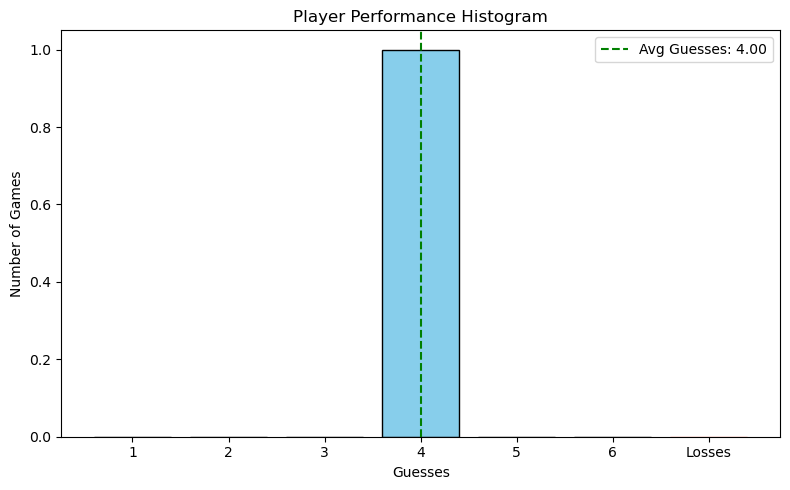

In [15]:
play_wordle()